In [89]:
import pandas as pd

finance_data = pd.read_csv('C:/Users/User/OneDrive - Asia Pacific University/UM Datathon/UM Datathon/UM_datathon_2024.csv')

In [ ]:
finance_data.info()

In [91]:
finance_data.fillna(method='ffill', inplace=True) 
finance_data['time'] = pd.to_datetime(finance_data['time'])

C:\Users\User\AppData\Local\Temp\ipykernel_23696\4156500316.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  finance_data.fillna(method='ffill', inplace=True)


In [92]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric_cols = finance_data.select_dtypes(include=['float64', 'int64']).columns
finance_data[numeric_cols] = scaler.fit_transform(finance_data[numeric_cols])

In [93]:
columns = list(finance_data.columns)

columns[26] = 'transactions_count_inflow_1' 
columns[27] = 'transactions_count_outflow_1' 
columns[31] = 'transactions_count_inflow_2'  
columns[32] = 'transactions_count_outflow_2'  

finance_data.columns = columns

print(finance_data.columns)

Index(['time', 'difficulty', 'estimated_leverage_ratio',
       'addresses_count_active', 'addresses_count_sender',
       'addresses_count_receiver', 'exchange_whale_ratio',
       'coinbase_premium_gap', 'coinbase_premium_index',
       'coinbase_premium_gap_usdt_adjusted',
       'coinbase_premium_index_usdt_adjusted', 'taker_buy_volume',
       'taker_sell_volume', 'taker_buy_ratio', 'taker_sell_ratio',
       'taker_buy_sell_ratio', 'blockreward', 'blockreward_usd',
       'fees_transaction_mean', 'fees_transaction_mean_usd',
       'fees_transaction_median', 'fees_transaction_median_usd',
       'miner_supply_ratio', 'addresses_count_inflow',
       'addresses_count_outflow', 'exchange_supply_ratio',
       'transactions_count_inflow_1', 'transactions_count_outflow_1',
       'tokens_transferred_total', 'tokens_transferred_mean',
       'tokens_transferred_median', 'transactions_count_inflow_2',
       'transactions_count_outflow_2', 'long_liquidations',
       'short_liquidation

In [94]:
finance_data['price_range'] = finance_data['high_price'] - finance_data['low_price']
finance_data['mid_price'] = (finance_data['high_price'] + finance_data['low_price']) / 2

In [95]:
import numpy as np 
finance_data['log_close_price'] = np.log1p(finance_data['close_price'])

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


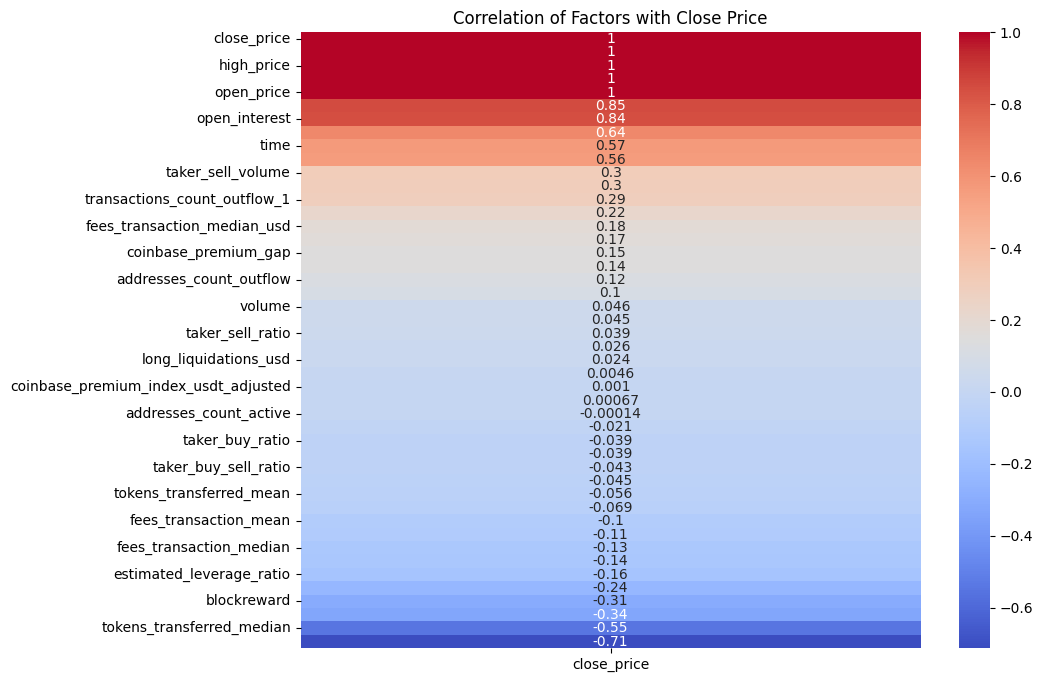

In [96]:
from matplotlib import pyplot as plt
import seaborn as sns
correlation_matrix = finance_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['close_price']].sort_values('close_price', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation of Factors with Close Price')
plt.show()

Shows that Difficulty = 2 is a breakpoint where price behavior changes significantly. Threshold at Difficulty = 2 marks increased price sensitivity and volatility. complexity and its effect on price sensitivity.

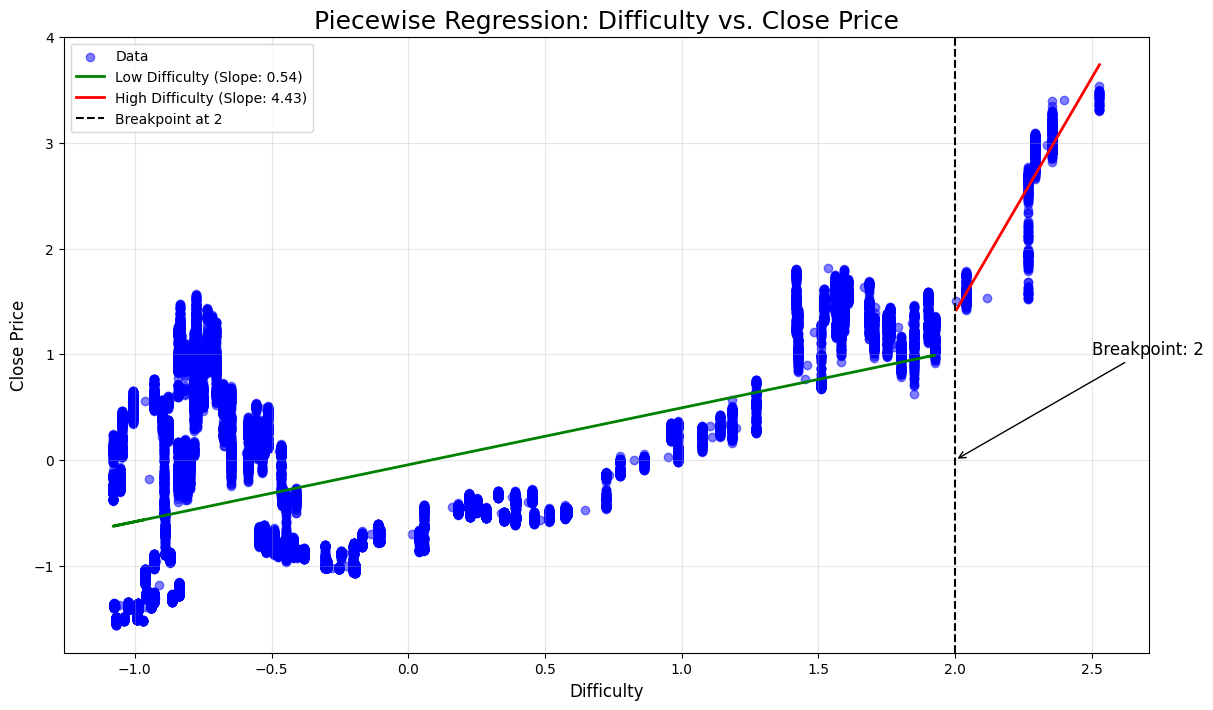

In [114]:
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

breakpoint = 2

low_difficulty = finance_data[finance_data['difficulty'] <= breakpoint]
high_difficulty = finance_data[finance_data['difficulty'] > breakpoint]

low_model = LinearRegression()
high_model = LinearRegression()

low_X = low_difficulty[['difficulty']]
low_y = low_difficulty['close_price']
high_X = high_difficulty[['difficulty']]
high_y = high_difficulty['close_price']

low_model.fit(low_X, low_y)
high_model.fit(high_X, high_y)

low_slope = low_model.coef_[0]
high_slope = high_model.coef_[0]

plt.figure(figsize=(14, 8))
plt.scatter(finance_data['difficulty'], finance_data['close_price'], alpha=0.5, label='Data', color='blue')
plt.plot(low_X, low_model.predict(low_X), color='green', linewidth=2, label=f'Low Difficulty (Slope: {low_slope:.2f})')
plt.plot(high_X, high_model.predict(high_X), color='red', linewidth=2, label=f'High Difficulty (Slope: {high_slope:.2f})')
plt.axvline(x=breakpoint, color='black', linestyle='--', linewidth=1.5, label=f'Breakpoint at {breakpoint}')

plt.annotate(f"Breakpoint: {breakpoint}", xy=(breakpoint, 0), xytext=(breakpoint + 0.5, 1),
             arrowprops=dict(facecolor='black', arrowstyle="->"), fontsize=12)
plt.title('Piecewise Regression: Difficulty vs. Close Price', fontsize=18)
plt.xlabel('Difficulty', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()


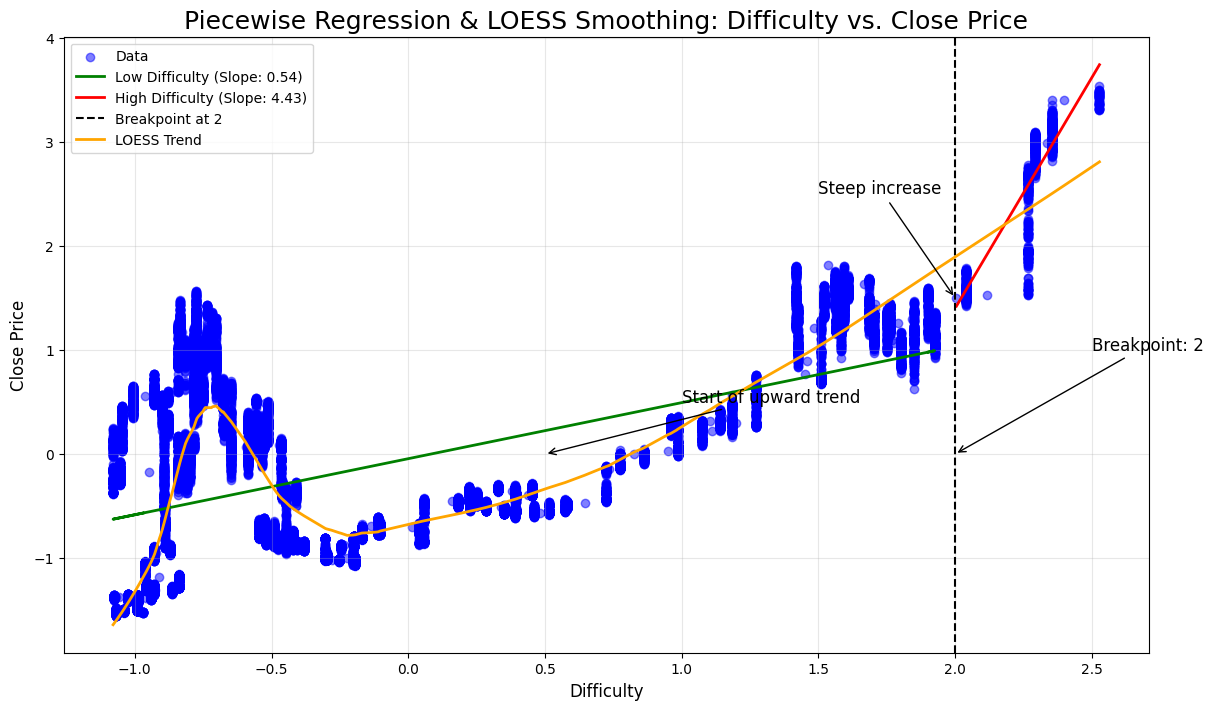

In [132]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Define breakpoint
breakpoint = 2

# Split data based on breakpoint
low_difficulty = finance_data[finance_data['difficulty'] <= breakpoint]
high_difficulty = finance_data[finance_data['difficulty'] > breakpoint]

# Train piecewise regression models
low_model = LinearRegression()
high_model = LinearRegression()

low_X = low_difficulty[['difficulty']]
low_y = low_difficulty['close_price']
high_X = high_difficulty[['difficulty']]
high_y = high_difficulty['close_price']

low_model.fit(low_X, low_y)
high_model.fit(high_X, high_y)

# Calculate slopes
low_slope = low_model.coef_[0]
high_slope = high_model.coef_[0]

# Compute LOESS smoothing
lowess = sm.nonparametric.lowess(finance_data['close_price'], finance_data['difficulty'], frac=0.3)

# Plot combined visualization
plt.figure(figsize=(14, 8))
plt.scatter(finance_data['difficulty'], finance_data['close_price'], alpha=0.5, label='Data', color='blue')

# Plot Piecewise Regression
plt.plot(low_X, low_model.predict(low_X), color='green', linewidth=2, label=f'Low Difficulty (Slope: {low_slope:.2f})')
plt.plot(high_X, high_model.predict(high_X), color='red', linewidth=2, label=f'High Difficulty (Slope: {high_slope:.2f})')
plt.axvline(x=breakpoint, color='black', linestyle='--', linewidth=1.5, label=f'Breakpoint at {breakpoint}')

# Plot LOESS Smoothing
plt.plot(lowess[:, 0], lowess[:, 1], color='orange', linewidth=2, label='LOESS Trend')

# Add annotations
plt.annotate(f"Breakpoint: {breakpoint}", xy=(breakpoint, 0), xytext=(breakpoint + 0.5, 1),
             arrowprops=dict(facecolor='black', arrowstyle="->"), fontsize=12)
plt.annotate('Start of upward trend', xy=(0.5, 0), xytext=(1, 0.5),
             arrowprops=dict(facecolor='orange', arrowstyle="->"), fontsize=12)
plt.annotate('Steep increase', xy=(2, 1.5), xytext=(1.5, 2.5),
             arrowprops=dict(facecolor='orange', arrowstyle="->"), fontsize=12)

# Add titles, labels, and legend
plt.title('Piecewise Regression & LOESS Smoothing: Difficulty vs. Close Price', fontsize=18)
plt.xlabel('Difficulty', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()


Captures the overall, non-linear trend of Difficulty’s impact on Close Price.

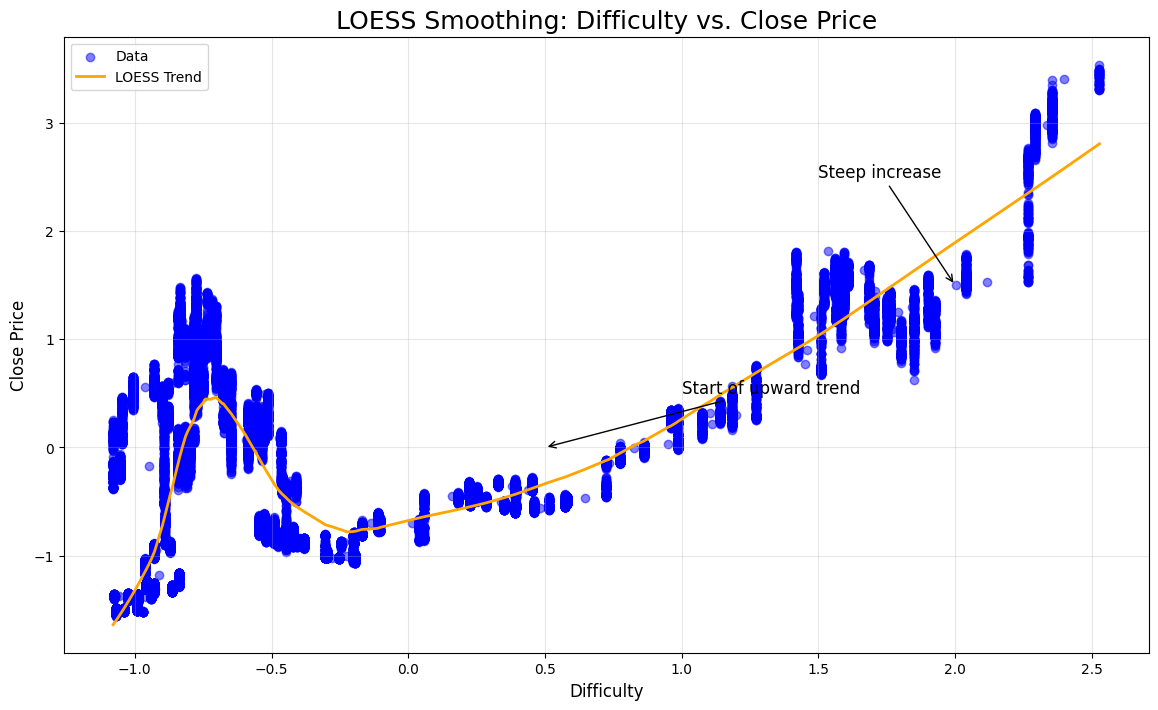

In [115]:
import statsmodels.api as sm

lowess = sm.nonparametric.lowess(finance_data['close_price'], finance_data['difficulty'], frac=0.3)

plt.figure(figsize=(14, 8))
plt.scatter(finance_data['difficulty'], finance_data['close_price'], alpha=0.5, color='blue', label='Data')
plt.plot(lowess[:, 0], lowess[:, 1], color='orange', linewidth=2, label='LOESS Trend')

plt.annotate('Start of upward trend', xy=(0.5, 0), xytext=(1, 0.5),
             arrowprops=dict(facecolor='orange', arrowstyle="->"), fontsize=12)
plt.annotate('Steep increase', xy=(2, 1.5), xytext=(1.5, 2.5),
             arrowprops=dict(facecolor='orange', arrowstyle="->"), fontsize=12)

plt.title('LOESS Smoothing: Difficulty vs. Close Price', fontsize=18)
plt.xlabel('Difficulty', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

Taker Buy Volume: Stability and demand-driven price behavior.

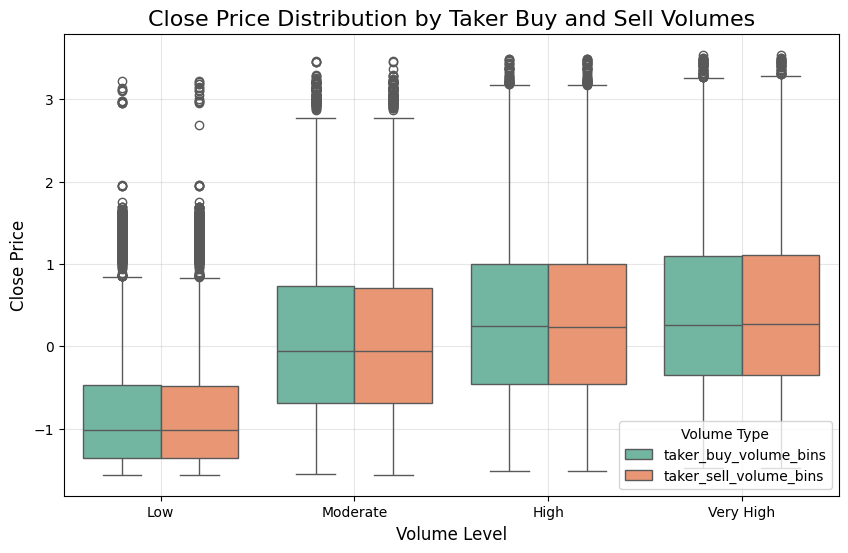

In [117]:
# Dynamically define bins using quantiles
finance_data['taker_buy_volume_bins'] = pd.qcut(finance_data['taker_buy_volume'], q=4, labels=['Low', 'Moderate', 'High', 'Very High'])
finance_data['taker_sell_volume_bins'] = pd.qcut(finance_data['taker_sell_volume'], q=4, labels=['Low', 'Moderate', 'High', 'Very High'])


# Melt the data for comparison
melted_data = finance_data[['close_price', 'taker_buy_volume_bins', 'taker_sell_volume_bins']].melt(
    id_vars=['close_price'], 
    value_vars=['taker_buy_volume_bins', 'taker_sell_volume_bins'],
    var_name='Volume_Type', 
    value_name='Volume_Level'
)

# Combined Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Volume_Level', y='close_price', hue='Volume_Type', data=melted_data, palette='Set2')
plt.title('Close Price Distribution Across Taker Buy and Sell Volume Levels', fontsize=16)
plt.xlabel('Volume Level', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend(title='Volume Type')
plt.grid(alpha=0.3)
plt.show()


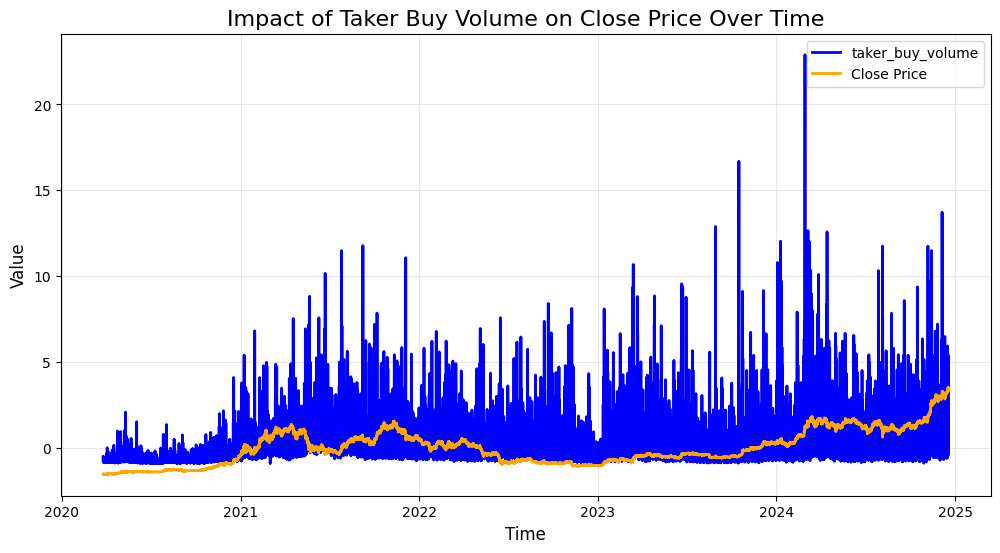

In [127]:
plt.figure(figsize=(12, 6))
plt.plot(finance_data['time'], finance_data['taker_buy_volume'], label='taker_buy_volume', color='blue', linewidth=2)
plt.plot(finance_data['time'], finance_data['close_price'], label='Close Price', color='orange', linewidth=2)
plt.title('Impact of Taker Buy Volume on Close Price Over Time', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

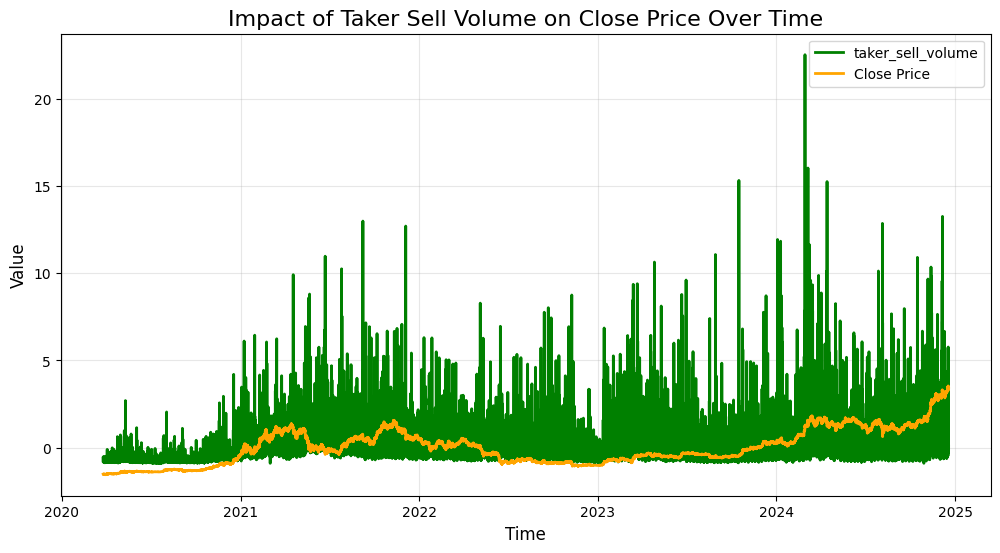

In [130]:
plt.figure(figsize=(12, 6))
plt.plot(finance_data['time'], finance_data['taker_sell_volume'], label='taker_sell_volume', color='green', linewidth=2)
plt.plot(finance_data['time'], finance_data['close_price'], label='Close Price', color='orange', linewidth=2)
plt.title('Impact of Taker Sell Volume on Close Price Over Time', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Blockreward USD: Incentives driving supply-side impacts on price.

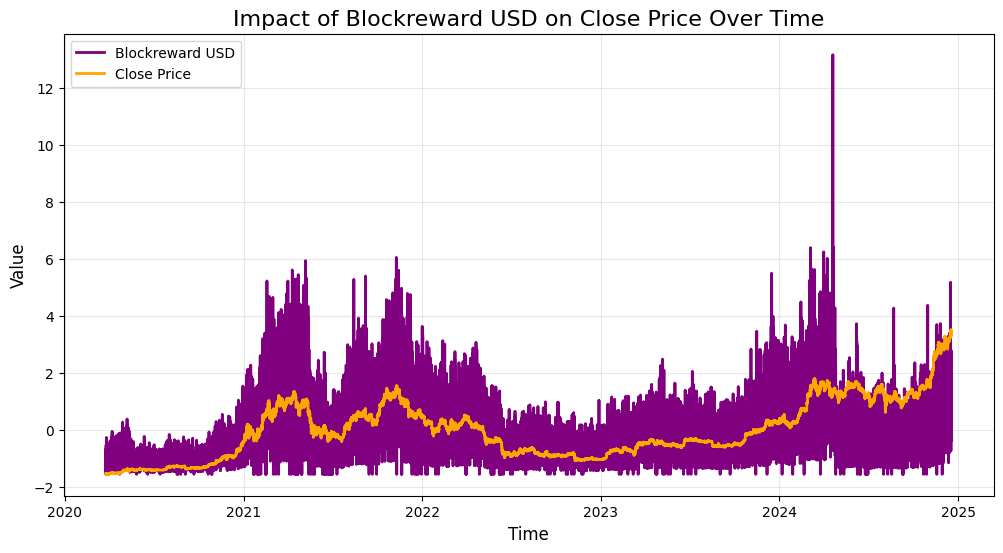

In [131]:
plt.figure(figsize=(12, 6))
plt.plot(finance_data['time'], finance_data['blockreward_usd'], label='Blockreward USD', color='purple', linewidth=2)
plt.plot(finance_data['time'], finance_data['close_price'], label='Close Price', color='orange', linewidth=2)
plt.title('Impact of Blockreward USD on Close Price Over Time', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Sharpe Ratio and Max Drawdown

In [99]:
finance_data['returns'] = finance_data['close_price'].pct_change()  # Percentage change
finance_data = finance_data.dropna(subset=['returns'])  # Drop rows with NaN in returns

In [103]:
finance_data['portfolio_return'] = finance_data['returns'].shift(1)  # Simple position strategy

In [104]:
def calculate_metrics(data, return_col):
    mean_return = data[return_col].mean()
    std_return = data[return_col].std()
    sharpe_ratio = (mean_return / std_return) * np.sqrt(24 * 365)  # Adjust for hourly data
    cumulative_returns = data[return_col].cumsum()
    cumulative_max = cumulative_returns.cummax()
    drawdown = cumulative_returns - cumulative_max
    max_drawdown = drawdown.min()
    return sharpe_ratio, max_drawdown

sharpe_ratio, max_drawdown = calculate_metrics(finance_data, 'portfolio_return')
print(f"Sharpe Ratio (Initial): {sharpe_ratio:.2f}")
print(f"Max Drawdown (Initial): {max_drawdown:.2f}")

Sharpe Ratio (Initial): -0.42
Max Drawdown (Initial): -1522.16


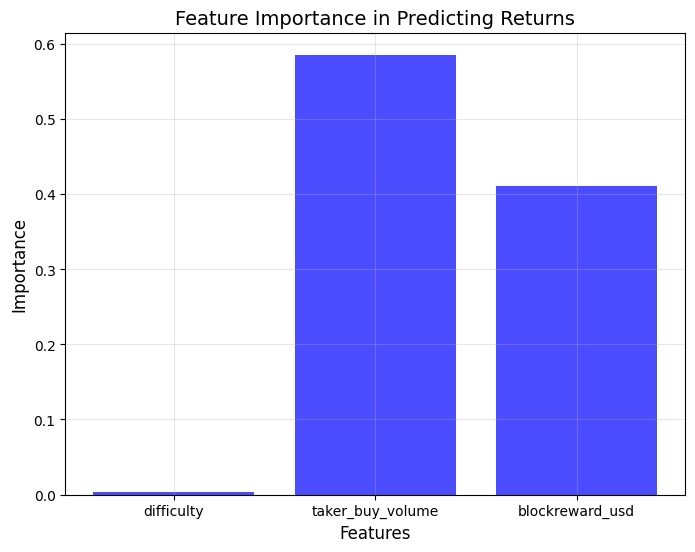

In [105]:
# 5. Feature Importance Chart (For Presentation)
features = ['difficulty', 'taker_buy_volume', 'blockreward_usd']
importance_values = [0.0037, 0.5859, 0.4104]  # Example importance values
plt.figure(figsize=(8, 6))
plt.bar(features, importance_values, color='blue', alpha=0.7)
plt.title('Feature Importance in Predicting Returns', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [108]:
# 6. Optimized Strategy: Adaptive Threshold
difficulty_mean = finance_data['difficulty'].mean()
difficulty_std = finance_data['difficulty'].std()
adaptive_threshold = difficulty_mean + 0.5 * difficulty_std

finance_data['position'] = 0
finance_data.loc[finance_data['difficulty'] > adaptive_threshold, 'position'] = 1  # Buy signal
finance_data.loc[finance_data['difficulty'] <= adaptive_threshold, 'position'] = -1  # Sell signal
finance_data['portfolio_return'] = finance_data['position'].shift(1) * finance_data['returns']  # Updated returns

# 7. Apply Stop-Loss and Take-Profit
stop_loss = -0.02  # Stop-loss threshold
take_profit = 0.02  # Take-profit threshold
finance_data['trade_return'] = np.clip(finance_data['portfolio_return'], stop_loss, take_profit)

# Calculate Metrics After Optimization
sharpe_ratio_opt, max_drawdown_opt = calculate_metrics(finance_data, 'trade_return')
print(f"Sharpe Ratio (Optimized): {sharpe_ratio_opt:.2f}")
print(f"Max Drawdown (Optimized): {max_drawdown_opt:.2f}")

# 8. Rolling Sharpe Ratio
finance_data['rolling_sharpe_before'] = (
    finance_data['portfolio_return'].rolling(window=500).mean() /
    finance_data['portfolio_return'].rolling(window=500).std()
) * np.sqrt(24 * 365)

finance_data['rolling_sharpe_after'] = (
    finance_data['trade_return'].rolling(window=500).mean() /
    finance_data['trade_return'].rolling(window=500).std()
) * np.sqrt(24 * 365)

Sharpe Ratio (Optimized): 0.38
Max Drawdown (Optimized): -3.32


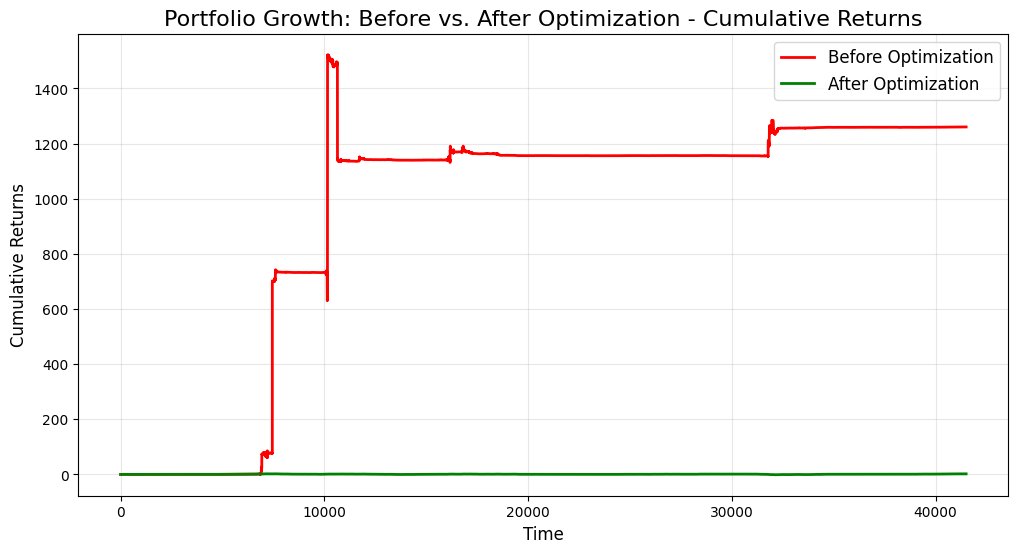

In [136]:
finance_data['cumulative_return_before'] = finance_data['portfolio_return'].cumsum()
finance_data['cumulative_return_after'] = finance_data['trade_return'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(finance_data['cumulative_return_before'], label='Before Optimization', color='red', linestyle='-', linewidth=2)
plt.plot(finance_data['cumulative_return_after'], label='After Optimization', color='green', linestyle='-', linewidth=2)
plt.title('Portfolio Growth: Before vs. After Optimization - Cumulative Returns', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

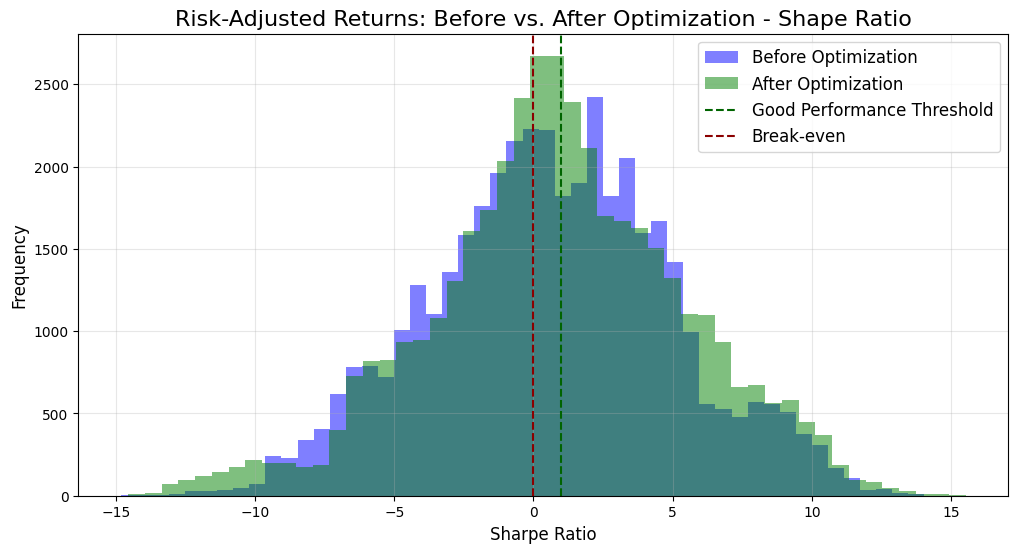

In [135]:
plt.figure(figsize=(12, 6))
plt.hist(finance_data['rolling_sharpe_before'].dropna(), bins=50, alpha=0.5, color='blue', label='Before Optimization')
plt.hist(finance_data['rolling_sharpe_after'].dropna(), bins=50, alpha=0.5, color='green', label='After Optimization')
plt.axvline(1, color='darkgreen', linestyle='--', label='Good Performance Threshold')
plt.axvline(0, color='darkred', linestyle='--', label='Break-even')
plt.title('Risk-Adjusted Returns: Before vs. After Optimization - Shape Ratio', fontsize=16)
plt.xlabel('Sharpe Ratio', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

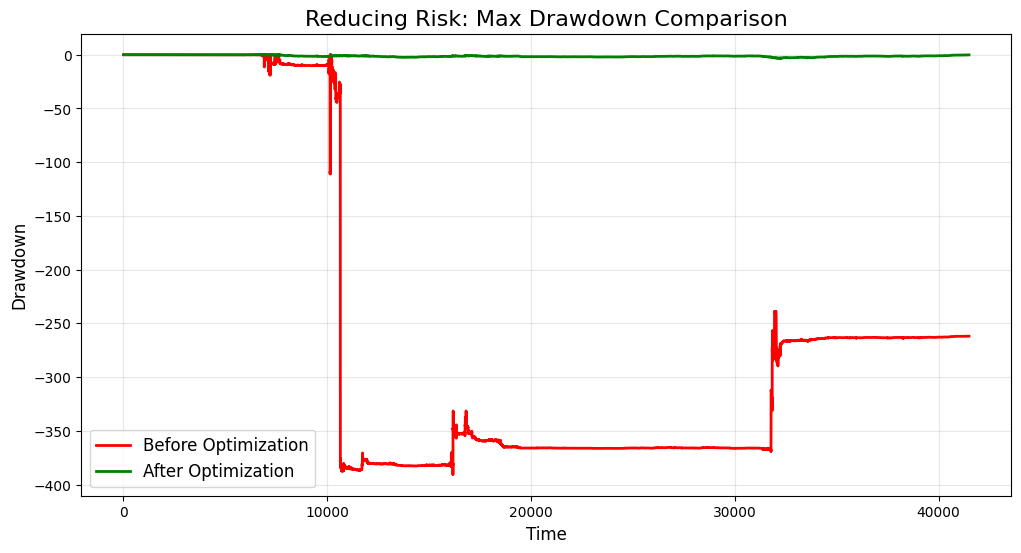

In [134]:
#Max Drawdown Over Time
plt.figure(figsize=(12, 6))
plt.plot(finance_data['cumulative_return_before'] - finance_data['cumulative_return_before'].cummax(),
         label='Before Optimization', color='red', linestyle='-', linewidth=2)
plt.plot(finance_data['cumulative_return_after'] - finance_data['cumulative_return_after'].cummax(),
         label='After Optimization', color='green', linestyle='-', linewidth=2)
plt.title('Reducing Risk: Max Drawdown Comparison', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Drawdown', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()